In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('/home/javidan/Downloads/essd_ghg_data.xlsx', sheet_name='data')

In [4]:
tmp_df = df.groupby(['country', 'year']).sum('value').reset_index()

In [5]:
tmp_df

,country,year,value (Gt)
0,Afghanistan,1970,2.189021e+06
1,Afghanistan,1971,2.186687e+06
2,Afghanistan,1972,2.130522e+06
3,Afghanistan,1973,2.143812e+06
4,Afghanistan,1974,2.627178e+06
...,...,...,...
11364,Zimbabwe,2016,1.202743e+07
11365,Zimbabwe,2017,1.136420e+07
11366,Zimbabwe,2018,1.355537e+07
11367,Zimbabwe,2019,1.260048e+07


In [8]:
fra_df = tmp_df[tmp_df['country'] == 'France']

In [9]:
fra_df

,country,year,value (Gt)
3419,France,1970,4.707363e+08
3420,France,1971,4.834908e+08
3421,France,1972,5.009728e+08
3422,France,1973,5.371110e+08
3423,France,1974,5.199614e+08
3424,France,1975,4.803236e+08
3425,France,1976,5.230787e+08
3426,France,1977,5.061880e+08
3427,France,1978,5.235447e+08
3428,France,1979,5.313617e+08


Text(0.5, 1.0, 'Forecasting')

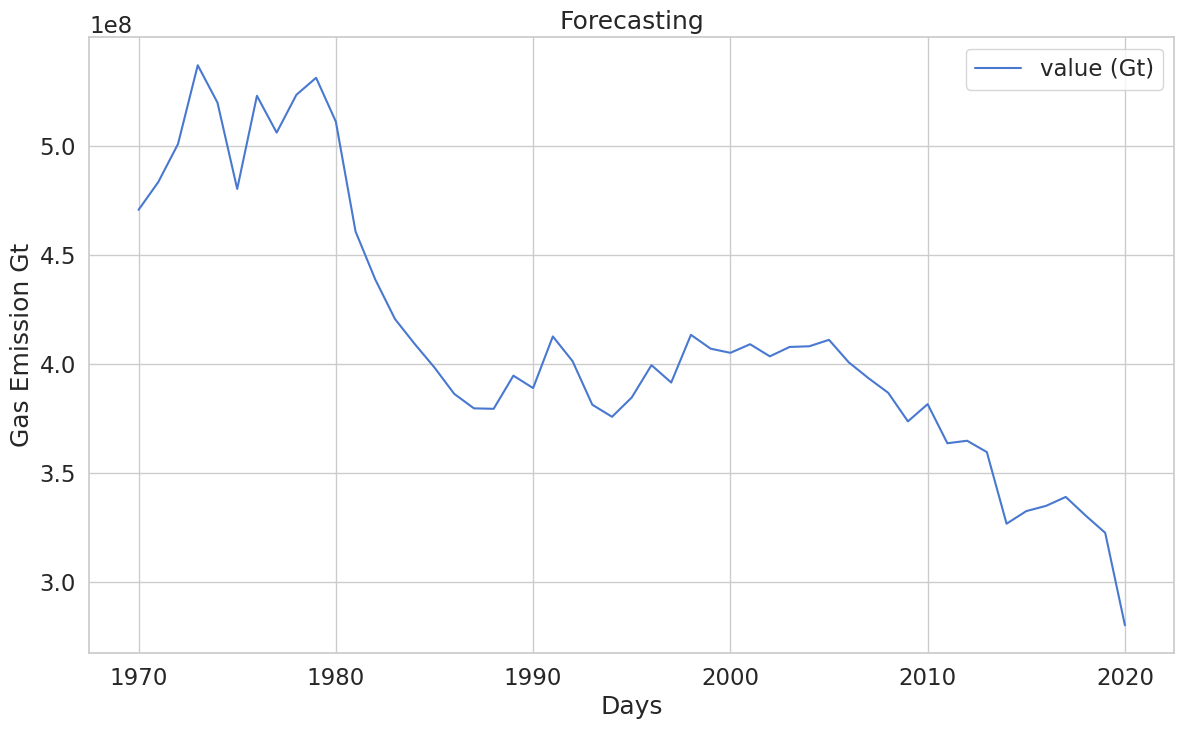

In [11]:
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = fra_df.plot(x='year', y='value (Gt)')
ax.set_xlabel('Days')
ax.set_ylabel('Gas Emission Gt')
ax.set_title('Forecasting')


In [24]:
tmp_df.shape

(11369, 3)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = tmp_df['value (Gt)'].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [23]:
scaled_close

array([[0.00018741],
       [0.00018721],
       [0.0001824 ],
       ...,
       [0.00116052],
       [0.00107877],
       [0.00098957]])

In [13]:
seq_len = 5

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.9)


In [14]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))


2023-12-08 14:20:54.793889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:
2023-12-08 14:20:54.793911: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-08 14:20:56.244182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:
2023-12-08 14:20:56.244287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/l

In [15]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
512/512 [==============================] - 12s 10ms/step - loss: 0.0018 - val_loss: 5.3404e-04
Epoch 2/10
512/512 [==============================] - 4s 7ms/step - loss: 0.0017 - val_loss: 4.4290e-04
Epoch 3/10
512/512 [==============================] - 3s 6ms/step - loss: 0.0014 - val_loss: 2.5974e-04
Epoch 4/10
512/512 [==============================] - 3s 6ms/step - loss: 8.5204e-04 - val_loss: 6.5765e-05
Epoch 5/10
512/512 [==============================] - 3s 6ms/step - loss: 3.9758e-04 - val_loss: 8.8686e-05
Epoch 6/10
512/512 [==============================] - 4s 7ms/step - loss: 5.1738e-04 - val_loss: 6.0714e-05
Epoch 7/10
512/512 [==============================] - 3s 6ms/step - loss: 3.4788e-04 - val_loss: 9.2283e-05
Epoch 8/10
512/512 [==============================] - 4s 7ms/step - loss: 4.9977e-04 - val_loss: 5.6879e-05
Epoch 9/10
512/512 [==============================] - 3s 7ms/step - loss: 4.2062e-04 - val_loss: 7.3799e-05
Epoch 10/10
512/512 [=================

36/36 [==============================] - 2s 2ms/step


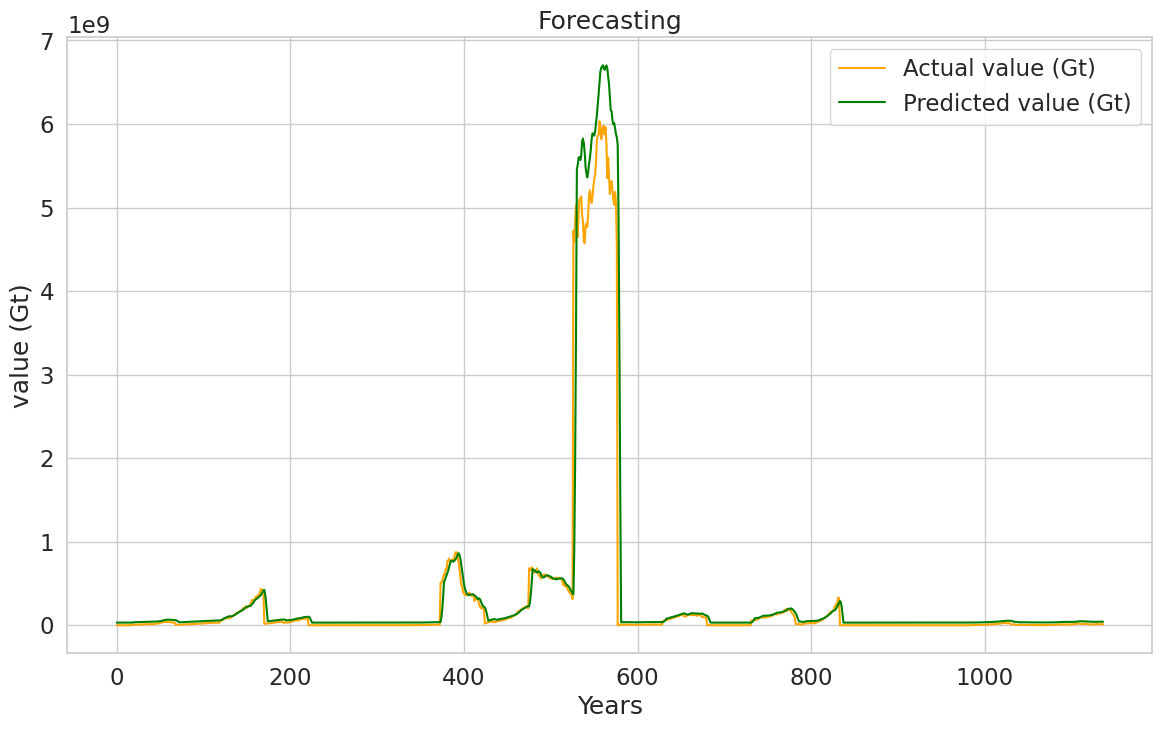

In [16]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual value (Gt)', color='orange')
plt.plot(y_pred_orig, label='Predicted value (Gt)', color='green')
 
plt.title('Forecasting')
plt.xlabel('Years')
plt.ylabel('value (Gt)')
plt.legend(loc='best')

plt.show()

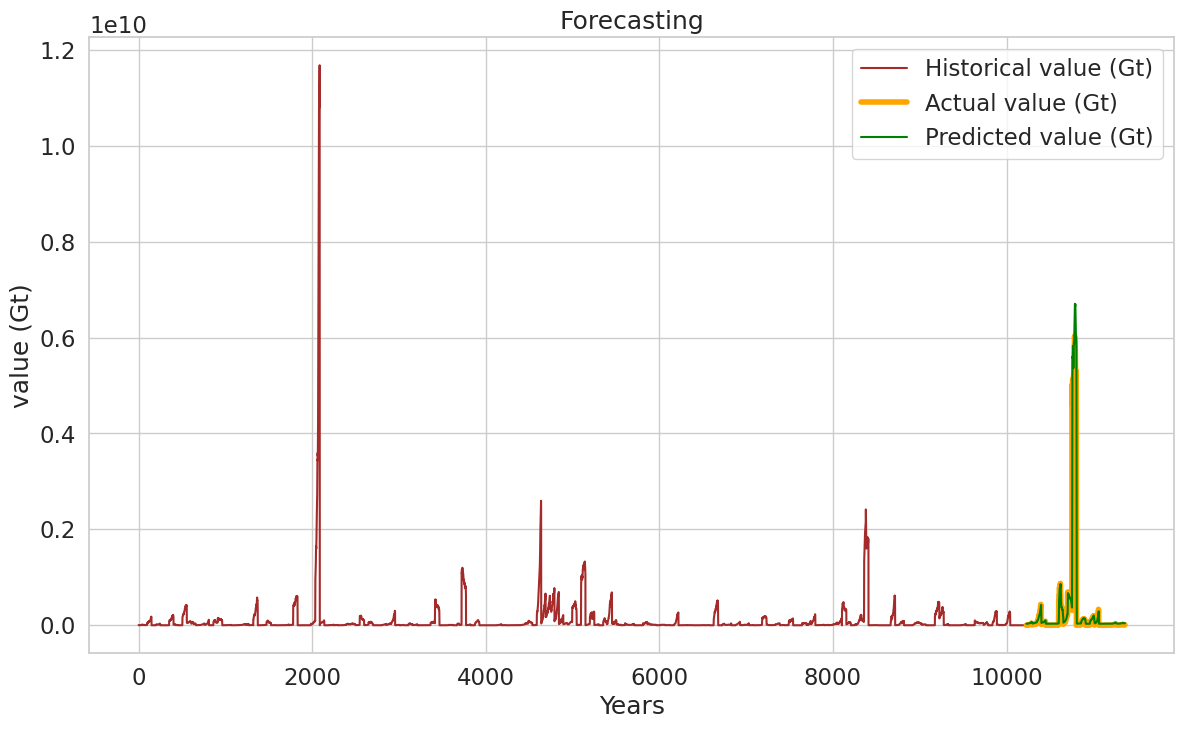

In [17]:
# plot for whole range of data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical value (Gt)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual value (Gt)', lw=4)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted value (Gt)')

plt.title('Forecasting')
plt.xlabel('Years')
plt.ylabel('value (Gt)')
plt.legend()
plt.show()
